In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import math

In [3]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal)#+noise)

In [4]:
mitbih = pd.read_csv("mitbih_test.csv")
mitbih_train = pd.read_csv("mitbih_train.csv")


In [5]:
data = mitbih_train.iloc[:, :186].values
labels = mitbih_train.iloc[:, 187].values

In [6]:
from keras.utils import to_categorical

one_hot_labels = np.zeros((len(labels), 5))
one_hot_labels[:] = to_categorical(labels[:], num_classes = 5)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size = 0.33, random_state = 42)

In [8]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Convolution1D, MaxPooling1D, SeparableConv1D, Flatten, MaxPool1D
from keras.optimizers import Adam
from keras.models import Model

X_train[:] = add_gaussian_noise(X_train[:])#Small data augmentation
X_test[:] = add_gaussian_noise(X_test[:])#Small data augmentation

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

im_shape=(X_train.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


model = Model(inputs= inputs_cnn, outputs=main_output)

In [9]:
model.compile(optimizer = Adam(lr = 100e-5), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [10]:
EPOCHS = 5
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = EPOCHS, shuffle = True, class_weight = 'auto')

Train on 46928 samples, validate on 11732 samples
Epoch 1/5
46928/46928 [==============================] - 46s 989us/step - loss: 0.1608 - accuracy: 0.9546 - val_loss: 0.1059 - val_accuracy: 0.9681
Epoch 2/5
46928/46928 [==============================] - 46s 988us/step - loss: 0.0940 - accuracy: 0.9732 - val_loss: 0.1269 - val_accuracy: 0.9638
Epoch 3/5
46928/46928 [==============================] - 44s 935us/step - loss: 0.0720 - accuracy: 0.9798 - val_loss: 0.1241 - val_accuracy: 0.9584
Epoch 4/5
46928/46928 [==============================] - 44s 935us/step - loss: 0.0615 - accuracy: 0.9818 - val_loss: 0.0784 - val_accuracy: 0.9783
Epoch 5/5
46928/46928 [==============================] - 46s 982us/step - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0708 - val_accuracy: 0.9805


In [11]:
print(model.evaluate(X_test, y_test))

28893/28893 [==============================] - 7s 241us/step
[0.0758509843394295, 0.9799951314926147]


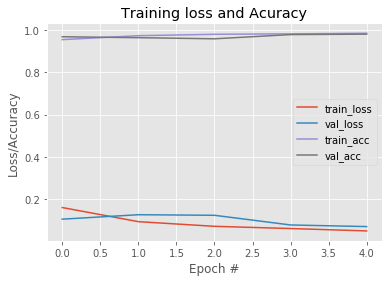

In [12]:
N = np.arange(0, EPOCHS)
title = "Training loss and Acuracy"

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label = "train_loss")
plt.plot(N, history.history["val_loss"], label = "val_loss")
plt.plot(N, history.history["accuracy"], label = "train_acc")
plt.plot(N, history.history["val_accuracy"], label = "val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Dodavanje par Dense slojeva i njihovo treniranje sa PTBDB dataset-om

In [13]:
ptbdb_abnormal = pd.read_csv("ptbdb_abnormal.csv", header = None)
ptbdb_normal = pd.read_csv("ptbdb_normal.csv", header = None)

In [14]:
data_ptb = []

data_ptb.extend(ptbdb_normal.iloc[:, :186].values)
data_ptb.extend(ptbdb_abnormal.iloc[:, :186].values)

labels_ptb = []
labels_ptb.extend(ptbdb_normal.iloc[:, 187].values)
labels_ptb.extend(ptbdb_abnormal.iloc[:, 187].values)

data_ptb = np.array(data_ptb)
labels_ptb = np.array(labels_ptb)

In [15]:
one_hot_labels_ptb = np.zeros((len(labels_ptb), 2))
one_hot_labels_ptb[:] = to_categorical(labels_ptb[:], num_classes = 2)

X_train_ptb, X_test_ptb, y_train_ptb, y_test_ptb = train_test_split(data_ptb, one_hot_labels_ptb, test_size=0.33, random_state=42)

X_train_ptb = X_train_ptb.reshape(len(X_train_ptb), X_train_ptb.shape[1],1)
X_test_ptb = X_test_ptb.reshape(len(X_test_ptb), X_test_ptb.shape[1],1)

In [16]:
dense_ptb1 = Dense(32, activation='relu')(model.layers[-3].output)
dense_ptb2 = Dense(16, activation='relu')(dense_ptb1)
dense_ptb3 = Dense(8, activation='relu')(dense_ptb2)
dense_ptb4 = Dense(2, activation='softmax')(dense_ptb3)

model_final = Model(inputs=model.input, outputs=dense_ptb4)

In [17]:

for layer in model_final.layers[:-4]:
    layer.trainable = False

for layer in model_final.layers[-4:]:
    layer.trainable = True

model_final.compile(optimizer = Adam(lr = 100e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
#batch_size

EPOCHS_ptb = 15
history_ptb = model_final.fit(X_train_ptb, y_train_ptb, validation_split=0.15, epochs=EPOCHS_ptb, batch_size=128)

Train on 8286 samples, validate on 1463 samples
Epoch 1/15
8286/8286 [==============================] - 3s 373us/step - loss: 1.0069 - accuracy: 0.6023 - val_loss: 0.4658 - val_accuracy: 0.7936
Epoch 2/15
8286/8286 [==============================] - 3s 320us/step - loss: 0.4245 - accuracy: 0.8047 - val_loss: 0.3858 - val_accuracy: 0.8243
Epoch 3/15
8286/8286 [==============================] - 3s 342us/step - loss: 0.3601 - accuracy: 0.8350 - val_loss: 0.3481 - val_accuracy: 0.8394
Epoch 4/15
8286/8286 [==============================] - 3s 326us/step - loss: 0.3189 - accuracy: 0.8545 - val_loss: 0.3258 - val_accuracy: 0.8551
Epoch 5/15
8286/8286 [==============================] - 3s 333us/step - loss: 0.2926 - accuracy: 0.8676 - val_loss: 0.3076 - val_accuracy: 0.8612
Epoch 6/15
8286/8286 [==============================] - 3s 331us/step - loss: 0.2702 - accuracy: 0.8788 - val_loss: 0.2971 - val_accuracy: 0.8688
Epoch 7/15
8286/8286 [==============================] - 3s 320us/step - loss

In [19]:
print(model_final.evaluate(X_test_ptb, y_test_ptb))

4803/4803 [==============================] - 1s 286us/step
[0.23782881393845617, 0.9023526906967163]


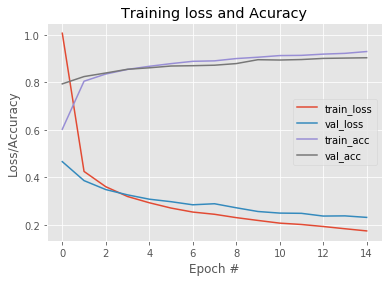

In [20]:
N = np.arange(0, EPOCHS_ptb)
title = "Training loss and Acuracy"

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history_ptb.history["loss"], label = "train_loss")
plt.plot(N, history_ptb.history["val_loss"], label = "val_loss")
plt.plot(N, history_ptb.history["accuracy"], label = "train_acc")
plt.plot(N, history_ptb.history["val_accuracy"], label = "val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_cnn (InputLayer)      (None, 186, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 181, 64)           448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 181, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 91, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 89, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 64)            0   

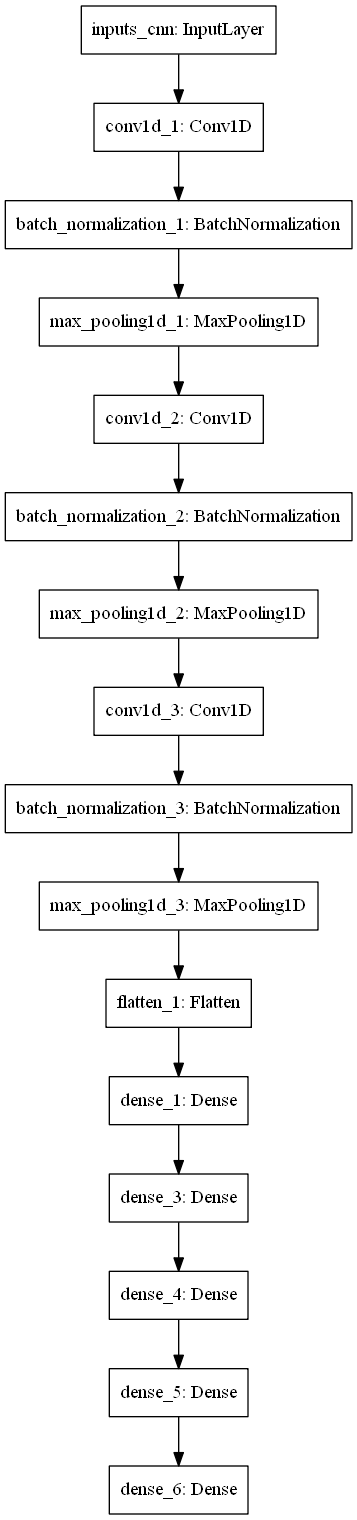

In [22]:
import pydot
from keras.utils.vis_utils import plot_model

print(model_final.summary())

import keras

import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

plot_model(model_final, to_file='transfer_learning.png')

In [24]:
predictions = model_final.predict(X_train_ptb)
predictions = np.where(predictions < 0.5, 0, 1)

In [26]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

accuracy = sklearn.metrics.accuracy_score(y_train_ptb, predictions)

print("Accuracy: {0:.2f}".format(100.0 * accuracy_score(y_train_ptb, predictions)))
print("Precision: {0:.2f}".format(100.0 * precision_score(y_train_ptb, predictions, average='micro')))
print("F1 score: {0:.2f}".format(100.0 * f1_score(y_train_ptb, predictions, average='micro')))

print('Classification Report:')
print(sklearn.metrics.classification_report(y_train_ptb, predictions))

Accuracy: 91.89
Precision: 91.89
F1 score: 91.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2697
           1       0.93      0.96      0.94      7052

   micro avg       0.92      0.92      0.92      9749
   macro avg       0.91      0.88      0.90      9749
weighted avg       0.92      0.92      0.92      9749
 samples avg       0.92      0.92      0.92      9749

